In [1]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
from numpy import linalg
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from pyEulerCurves import difference_ECC
from pyEulerCurves import ECC_from_pointcloud, plot_euler_curve
import time
from sklearn.metrics import pairwise_distances

In [2]:
import scipy
scipy.__version__

'1.7.3'

In [3]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values

/home/nihell/.local/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in data:
        ec = sampled_ecc_alpha(dat.reshape(-1,1), n_samples, max_filt_val)
        eccs.append(ec)
    return eccs

In [5]:
def ecc_distance_matrix(ECCs1, ECCs2, n_samples, max_filt_val):
    dists = pairwise_distances(ECCs1,ECCs2, n_jobs=-1)
    dists = dists *(max_filt_val/(n_samples-1))
    return dists

In [6]:
def train_statistics(RV, N, n_samples, n_samples_test, q=0.95):
    samples_topo = gen_rv(RV, N, n_samples=n_samples)
    samples_std = [standarize_sample_columns(s) for s in samples_topo]
    samples = samples_std.copy()
    
    eccs = get_ecc(samples, 101,0.1)
    
    W1_train = ecc_distance_matrix(eccs, eccs, 101, 0.1)

    samples_test = gen_rv(RV, N, n_samples=n_samples_test)
    samples_test = [standarize_sample_columns(s) for s in samples_test]
    
    eccs_test = get_ecc(samples_test, 101, 0.1)
    W1_test = ecc_distance_matrix(eccs, eccs_test, 101, 0.1)

    dmean = np.mean(W1_test, axis=1)
    dmin = np.min(W1_test, axis=1)
    dmax = np.max(W1_test, axis=1)
    dq = np.quantile(W1_test, q=0.9, axis=1)
    qmean = np.quantile(dmean, q)
    qmin = np.quantile(dmin, q)
    qmax = np.quantile(dmax, q)
    qq = np.quantile(dq, q)
    return eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq

In [7]:
def topo_test(samples, eccs, qmin, qmean, qmax, qq):
    #print("topo_test before ecc")
    #tic = time.time()
    eccs_test = get_ecc(samples, 101, 0.1)
    #print("Alpha complexes and ECCs computed in ", time.time()-tic)
    #tic = time.time()
    W1_test = ecc_distance_matrix(eccs, eccs_test, 101, 0.1)
    #print("Distance matrix computed in ", time.time()-tic)
    dmin = np.min(W1_test, axis=1)
    dmax = np.max(W1_test, axis=1)
    dmean = np.mean(W1_test, axis=1)
    dq = np.quantile(W1_test, q=0.9, axis=1) # takie samo q jak w train_statistcs
    
    is_normal_min = dmin < qmin
    is_normal_mean = dmean < qmean
    is_normal_max = dmax < qmax
    is_normal_q = dq < qq
    
    p_empirical_min = np.sum(is_normal_min)/len(is_normal_min)
    p_empirical_mean = np.sum(is_normal_mean)/len(is_normal_mean)
    p_empirical_max = np.sum(is_normal_max)/len(is_normal_max)
    p_empirical_q = np.sum(is_normal_q)/len(is_normal_q)
    #print("topo_test done")
    return p_empirical_min, p_empirical_mean, p_empirical_max, p_empirical_q

def normality_tests(samples):

    hz = [pg.multivariate_normality(sample).pval >0.05 for sample in samples]
    
    hz = np.sum(hz)/len(hz)

    return hz#shapiro, ks, ad, cvm

In [8]:
def gen_rv(rv, N, n_samples):
    return [np.array([rv[0].rvs(N), rv[1].rvs(N).tolist()]).T for i in range(n_samples)]


def standarize(X, mu, sigma):
    #mu = np.mean(X, axis=0)
    #sigma = np.cov(X, rowvar=False)
    sigma_inv = np.linalg.inv(sigma)
    A = scipy.linalg.sqrtm(sigma_inv)
    Xstd = A.dot((X-mu).T).T
    return Xstd

def standarize_sample_columns(X):
    mu = np.mean(X, axis=0)
    sd = np.std(X, axis=0)
    X -= mu
    X /= sd
    return X

In [9]:
# generate other distributions to measure test power
# first check normal distribution
def empirical_test_power(RV, eccs, qmin, qmean, qmax, qq, N=100, n_samples=250):
    samples_topo = gen_rv(RV, N, n_samples=n_samples)
    samples = [standarize_sample_columns(s) for s in samples_topo]

    #print("in empirical_test_power, after standardizing")
    topo_min, topo_mean, topo_max, topo_q = topo_test(samples_topo, eccs, qmin, qmean, qmax, qq)
    #print("in empirical_test_power, after topo_test")
    power_hz = normality_tests(samples)
    #print("done with empirical_test_power")
    return topo_min, topo_mean, topo_max, topo_q, power_hz

In [10]:
# https://www.semanticscholar.org/paper/Power-comparisons-of-Shapiro-Wilk-%2C-%2C-Lilliefors-Razali-Wah/dcdc0a0be7d65257c4e6a9117f69e246fb227423

rv_normal = st.norm()
rv_normal2_2 = st.norm(2,2)
rv_beta2_2 = st.beta(2, 2)
rv_beta5_5 = st.beta(5, 5)
rv_beta10_10 = st.beta(10, 10)
rv_laplace = st.laplace()
rv_uniform = st.uniform()
rv_t3 = st.t(df=3)
rv_t5 = st.t(df=5)
rv_t7 = st.t(df=7)
rv_t10 = st.t(df=10)
rv_gamma10_1 = st.gamma(10,1)
rv_gamma20_1 = st.gamma(20,1)
rv_gamma4_5 = st.gamma(4,5)
rv_gamma5_1= st.gamma(5,1)
rv_chisq4 = st.chi2(df=4)
rv_chisq10 = st.chi2(df=10)
rv_lorentz = st.cauchy()

wasserstein_p = 1
wasserstein_order = 1
standarize_data = True

outputfilename = f'results/{standarize_data}_distrib_std_ECC3d'

rvs = [[rv_normal, rv_normal, rv_normal],
[rv_normal, rv_normal2_2, rv_normal2_2],
[rv_lorentz, rv_lorentz, rv_lorentz],
[rv_t3, rv_t3, rv_t3],
[rv_t10, rv_t10, rv_t10],
[rv_chisq10, rv_chisq10, rv_chisq10],
[rv_normal, rv_t10, rv_t10],
[rv_normal, rv_normal, rv_t10],
[rv_normal, rv_chisq10, rv_chisq10],
[rv_normal, rv_gamma5_1, rv_gamma5_1],
[rv_normal, rv_lorentz, rv_lorentz],
[rv_normal, rv_t3, rv_t10],
[rv_normal, rv_uniform, rv_beta2_2]
]
rv_names = ['NxNxN', 'NxN22xN22', 'Lor x Lor x Lor', 'T3xT3xT3', 'T10xT10xT10', 'ChiSq10xChiSq10xChiSq10',
            'NxT10xT10', 'NxNxT10', 'NxChiSq10xChiSq10', 'NxGamma51xGamma51', 'NxLorxLor', 'NxT3xT10','NxUxBeta22']

In [11]:
n_samples = 500
mc_loops = 750
results = defaultdict(list)
resuts_stats = {}

for N in [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # compute the  distance matrix for normal distribution for given data size N
    eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq = train_statistics(rvs[0], N=N, n_samples=n_samples, n_samples_test=mc_loops, q=0.95)
    resuts_stats[N] = [eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq]
    
    for rv, rv_name in zip(rvs, rv_names):
        print(f'N={N} rv_name={rv_name}')
        results[rv_name].append([N, *empirical_test_power(RV=rv, eccs=eccs, qmin=qmin, qmean=qmean, qmax=qmax, qq=qq, N=N, n_samples=mc_loops)])
    
    np.save(outputfilename+'AlphaECC3d.npy', results)
    np.save(outputfilename+'AlphaECC3d_stats.npy', resuts_stats)

N=50 rv_name=NxNxN
N=50 rv_name=NxN22xN22
N=50 rv_name=Lor x Lor x Lor
N=50 rv_name=T3xT3xT3
N=50 rv_name=T10xT10xT10
N=50 rv_name=ChiSq10xChiSq10xChiSq10
N=50 rv_name=NxT10xT10
N=50 rv_name=NxNxT10
N=50 rv_name=NxChiSq10xChiSq10
N=50 rv_name=NxGamma51xGamma51
N=50 rv_name=NxLorxLor
N=50 rv_name=NxT3xT10
N=50 rv_name=NxUxBeta22
N=100 rv_name=NxNxN
N=100 rv_name=NxN22xN22
N=100 rv_name=Lor x Lor x Lor
N=100 rv_name=T3xT3xT3
N=100 rv_name=T10xT10xT10
N=100 rv_name=ChiSq10xChiSq10xChiSq10
N=100 rv_name=NxT10xT10
N=100 rv_name=NxNxT10
N=100 rv_name=NxChiSq10xChiSq10
N=100 rv_name=NxGamma51xGamma51
N=100 rv_name=NxLorxLor
N=100 rv_name=NxT3xT10
N=100 rv_name=NxUxBeta22
N=150 rv_name=NxNxN
N=150 rv_name=NxN22xN22
N=150 rv_name=Lor x Lor x Lor
N=150 rv_name=T3xT3xT3
N=150 rv_name=T10xT10xT10
N=150 rv_name=ChiSq10xChiSq10xChiSq10
N=150 rv_name=NxT10xT10
N=150 rv_name=NxNxT10
N=150 rv_name=NxChiSq10xChiSq10
N=150 rv_name=NxGamma51xGamma51
N=150 rv_name=NxLorxLor
N=150 rv_name=NxT3xT10
N=150 rv_

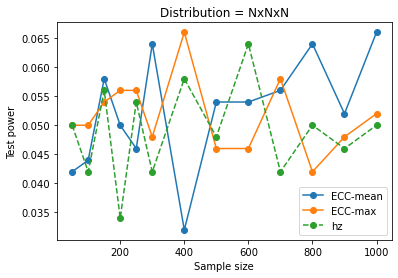

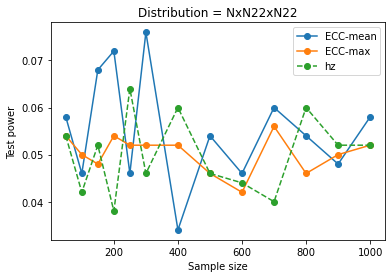

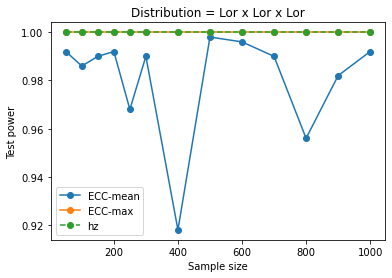

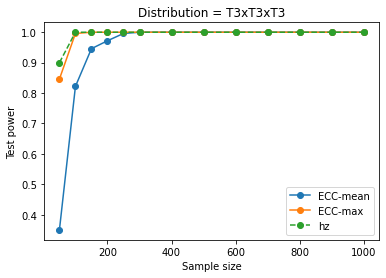

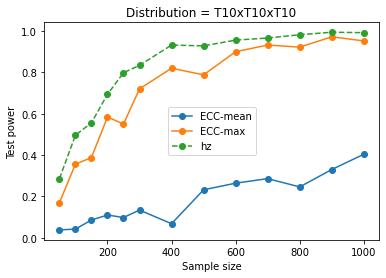

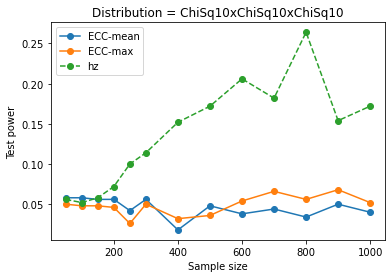

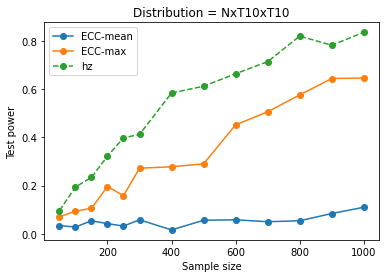

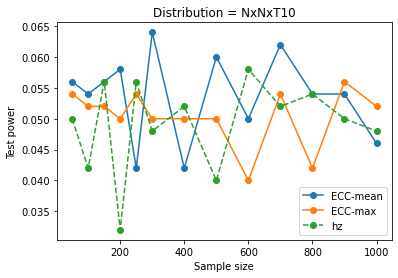

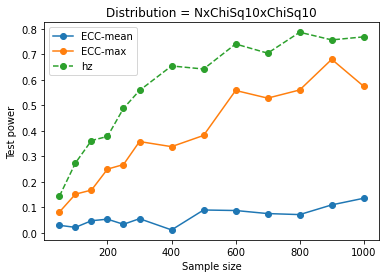

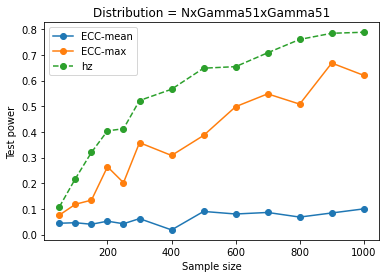

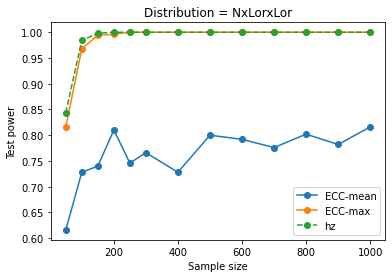

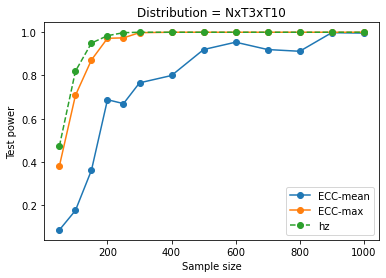

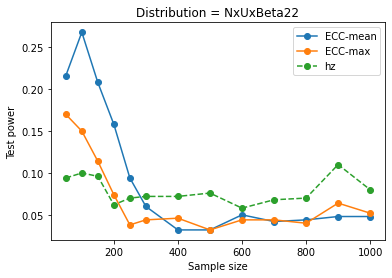

In [12]:
for dist_name in results.keys():
    data = results[dist_name]
    data = np.array(data)

    plt.plot(data[:, 0], 1-data[:, 1], 'o-', label='ECC-mean')
    plt.plot(data[:, 0], 1-data[:, 2], 'o-', label='ECC-max')
    #plt.plot(data[:, 0], 1-data[:, 3], 'o-', label='ECC-q')
    plt.plot(data[:, 0], 1-data[:, 4], 'o--', label='hz')

    plt.xlabel('Sample size')
    plt.ylabel('Test power')
    plt.title(f'Distribution = {dist_name}')
    plt.legend()
    plt.savefig(outputfilename+'_'+dist_name+'_AlphaECC3d.png')
    plt.show()